In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import numpy as np
from sklearn.model_selection import GridSearchCV
from time import time

%matplotlib inline

In [2]:
df_train = pd.read_csv("data/churn_train.csv")
df_test = pd.read_csv("data/churn_test.csv")

In [3]:
df_train = pd.read_csv("data/churn_train.csv")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      39838 non-null float64
avg_rating_of_driver      33472 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
last_trip_date            40000 non-null object
phone                     39681 non-null object
signup_date               40000 non-null object
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.4+ MB


In [4]:
def replace_nans(df):
    # replace Nan with mean 
    avg_rating_by_driver_mean = np.mean(df["avg_rating_by_driver"])
    avg_rating_of_driver_mean = np.mean(df["avg_rating_of_driver"])
    df["avg_rating_by_driver"].fillna(avg_rating_by_driver_mean, inplace=True)
    df["avg_rating_of_driver"].fillna(avg_rating_of_driver_mean, inplace=True)

In [5]:
def clean_data(df):
    df1 = df[~pd.isnull(df).any(axis=1)]
    # creat dummy vars for [city, phone]
    df2 = pd.get_dummies(df1, columns=['city','phone'], drop_first=False)
    # Add dates
    df2["signup_date"] = pd.to_datetime(df2["signup_date"])
    df2["last_trip_date"] = pd.to_datetime(df2["last_trip_date"])
    df2["Days Active"] =  (df2["last_trip_date"]-df2["signup_date"]).dt.days
    # Add target
    df2["target"] = df2["last_trip_date"]>pd.Timestamp("2014-06-01")
    return df2

In [6]:
replace_nans(df_train)
replace_nans(df_test)
df2 = clean_data(df_train)
df_test = clean_data(df_test)

In [7]:
df2.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,Days Active,target
0,6.94,5.0,5.000000,1.00,2014-05-03,2014-01-12,0.0,0,False,100.0,1,0,0,1,0,111,False
1,8.06,5.0,5.000000,1.00,2014-01-26,2014-01-25,0.0,2,True,0.0,1,0,0,1,0,1,False
2,21.50,4.0,4.601697,1.00,2014-05-21,2014-01-02,0.0,1,True,100.0,0,0,1,0,1,139,False
3,9.46,5.0,4.601697,2.75,2014-01-10,2014-01-09,100.0,1,False,100.0,0,0,1,1,0,1,False
4,13.77,5.0,4.601697,1.00,2014-05-13,2014-01-31,0.0,0,False,100.0,0,0,1,0,1,102,False


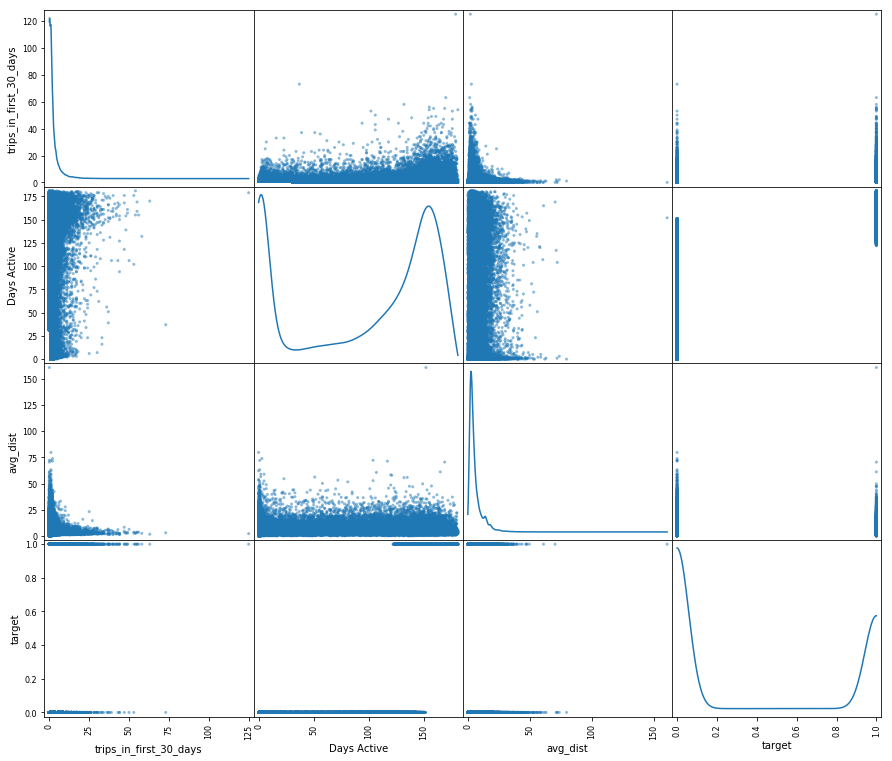

In [8]:
from pandas.plotting import scatter_matrix
df_scat = pd.DataFrame(df2, columns=["trips_in_first_30_days", "Days Active", "avg_dist", "target"])
scatter_matrix(df_scat,figsize=(15, 13), diagonal="kde")
plt.show()

In [9]:
y = df2.pop("target").values
df2.drop(["last_trip_date","signup_date", "Days Active"], axis=1, inplace=True)
X = df2.values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [11]:
#first out of the bag model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)

In [12]:
#checking the score
rf.score(X_test, y_test)

0.75597218022376778

In [13]:
# feature importance
rf.feature_importances_

array([ 0.29068361,  0.10942789,  0.08220865,  0.05675078,  0.09452915,
        0.08375481,  0.03360913,  0.12762686,  0.0204427 ,  0.05121476,
        0.00852318,  0.0190893 ,  0.02213918])

In [14]:
df2.columns[np.argsort(rf.feature_importances_)[::-1]]

Index(['avg_dist', 'weekday_pct', 'avg_rating_by_driver', 'surge_pct',
       'trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'city_King's Landing', 'luxury_car_user', 'phone_iPhone',
       'city_Astapor', 'phone_Android', 'city_Winterfell'],
      dtype='object')

In [15]:
confusion_matrix(y_test, y_predict)

array([[5275, 1019],
       [1402, 2225]])

In [16]:
#Tweeking hyperparameters

In [17]:
# use a full grid over all parameters
param_grid = {"n_estimators": [100,140,160,200],
              "max_depth": [30],
              "max_features": [3],
              "min_samples_split": [12],
              "min_samples_leaf": [10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
start = time()
grid_search = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, n_jobs=-1)

grid_search.fit(X_train, y_train)
end = time()

In [34]:
print("Run time: {}s".format(round(end - start, 2)))

Run time: 54.64s


In [19]:
#Checking to see estimators with best results
rf2 = grid_search.best_estimator_
rf2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=30, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=12,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [37]:
#scoring train data
print("Accuracy of train data: {}%".format(round(rf2.score(X_test, y_test) * 100, 2)))

Accuracy of train data: 79.2%


In [21]:
y = df_test.pop("target").values
df_test.drop(["last_trip_date","signup_date", "Days Active"], axis=1, inplace=True)
X = df_test.values

In [35]:
#scoring test data
print("Accuracy of test data: {}%".format(round(rf2.score(X, y) * 100, 2)))

Accuracy of test data: 78.13%


In [23]:
df_test.columns[np.argsort(rf2.feature_importances_)[::-1]]

Index(['avg_rating_by_driver', 'weekday_pct', 'avg_dist', 'surge_pct',
       'city_King's Landing', 'avg_surge', 'trips_in_first_30_days',
       'luxury_car_user', 'avg_rating_of_driver', 'phone_iPhone',
       'phone_Android', 'city_Astapor', 'city_Winterfell'],
      dtype='object')

In [24]:
#creating prediction
y_pred = rf2.predict(X)

In [25]:
#creating confusion matrix with sklearn
confusion_matrix(y, y_pred)

array([[5443,  839],
       [1331, 2310]])

In [26]:
#function for correct confusion matrix
def standard_confusion_matrix(y, y_pred):
    [[tn, fp], [fn, tp]] = confusion_matrix(y, y_pred)
    return np.array([[tp, fp], [fn, tn]])

In [27]:
#correct confusion matrix
standard_confusion_matrix(y, y_pred)

array([[2310,  839],
       [1331, 5443]])

In [28]:
#predicted probabilities
scores = rf2.predict_proba(X)

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(y, scores[:,0], pos_label=1)

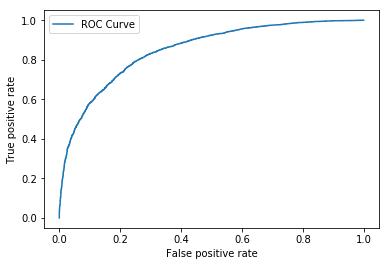

In [30]:
#Plotting the ROC curve
plt.plot(tpr, fpr, label="ROC Curve")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.show()

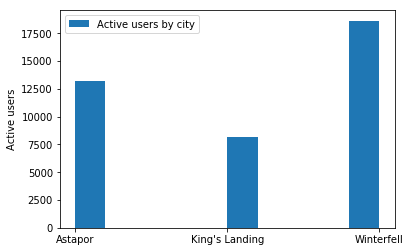

In [31]:
#From feature importance it seemed like King's Landing had an impact on the prediction
#from the histogram it makes sense because King's Landing has the lowest active users
plt.hist(df_train["city"], label="Active users by city")
plt.ylabel("Active users")
plt.legend()
plt.show()